<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.7MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=ab74bcc68731105fc07e554457d45ea4f070ed731a223360caea1a959cafd76b
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [8]:
df_kanja.shape

(1866, 10)

In [9]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1864 non-null   Int64 
 1   発表日     1864 non-null   object
 2   年代      1864 non-null   object
 3   性別      1864 non-null   object
 4   管轄      1864 non-null   object
 5   居住地     1864 non-null   object
 6   職業      1863 non-null   object
 7   発症日     1864 non-null   object
 8   渡航歴     1864 non-null   object
 9   備考欄     1863 non-null   object
dtypes: Int64(1), object(9)
memory usage: 147.7+ KB


In [10]:
df_kanja.count()

番号     1864
発表日    1864
年代     1864
性別     1864
管轄     1864
居住地    1864
職業     1863
発症日    1864
渡航歴    1864
備考欄    1863
dtype: int64

# 前処理

In [11]:
import datetime

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import numpy as np

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [12]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [13]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [14]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [15]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.drop(738, inplace=True)

In [16]:
# 職業
df_kanja["職業"] = df_kanja["職業"].str.replace("\n", "")

In [17]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [18]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [19]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

In [20]:
df_kanja.to_csv("kanja.tsv", sep="\t")

# 経過日数確認

## 経過日数グラフ

Text(0.98, 0.85, 'median: 6.0')

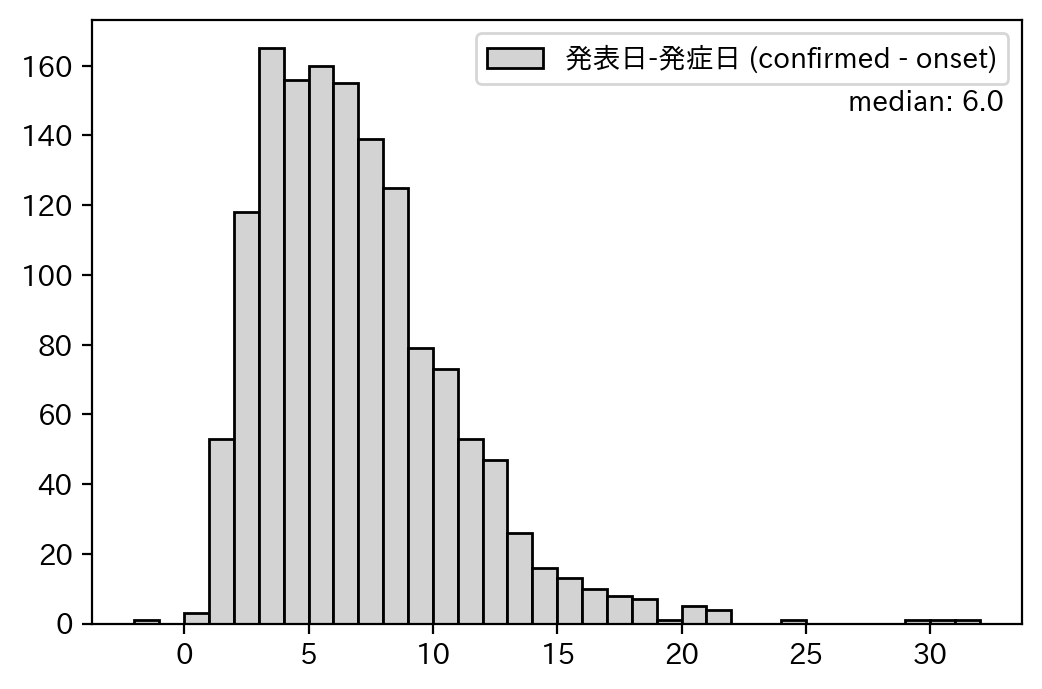

In [21]:
df_kanja["経過日数"] = (df_kanja["発表日"] - df_kanja["発症日"]).dt.days

df_kanja["経過日数"].dropna(inplace=True)

fig, ax = plt.subplots()
ax.hist(df_kanja["経過日数"], bins=np.arange(min(df_kanja["経過日数"]), max(df_kanja["経過日数"])+2), color="lightgray", edgecolor="black")
ax.legend(['発表日-発症日 (confirmed - onset)'])
ax.text(0.98, 0.85, 'median: ' + str(np.median(df_kanja["経過日数"])), horizontalalignment='right', transform=ax.transAxes)

## 経過日数一覧

In [22]:
df_kanja["経過日数"].value_counts().sort_index()

-2.0       1
 0.0       3
 1.0      53
 2.0     118
 3.0     165
 4.0     156
 5.0     160
 6.0     155
 7.0     139
 8.0     125
 9.0      79
 10.0     73
 11.0     53
 12.0     47
 13.0     26
 14.0     16
 15.0     13
 16.0     10
 17.0      8
 18.0      7
 19.0      1
 20.0      5
 21.0      4
 24.0      1
 29.0      1
 30.0      1
 31.0      1
Name: 経過日数, dtype: int64

# 発症日グラフ

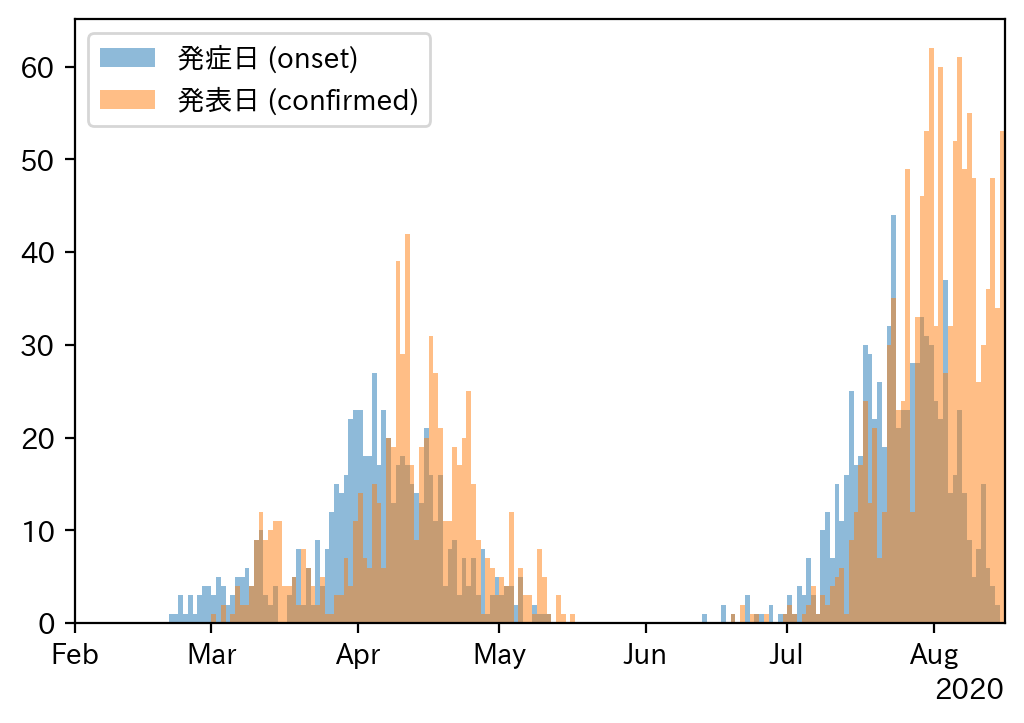

In [23]:
b = np.arange(min(min(df_kanja['発表日']), min(df_kanja['発症日'])),
              max(max(df_kanja['発表日']), max(df_kanja['発症日'])) + datetime.timedelta(days=2),
              datetime.timedelta(days=1))

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.hist(df_kanja['発症日'].values, bins=b, alpha=0.5) # edgecolor="black"
ax.hist(df_kanja['発表日'].values, bins=b, alpha=0.5)
ax.legend(['発症日 (onset)', '発表日 (confirmed)'])
ax.set_xlim(datetime.datetime(2020,2,1), b[-1])
fig.savefig('hyogo.svg', bbox_inches="tight")

# 年代確認

## 年代別グラフ

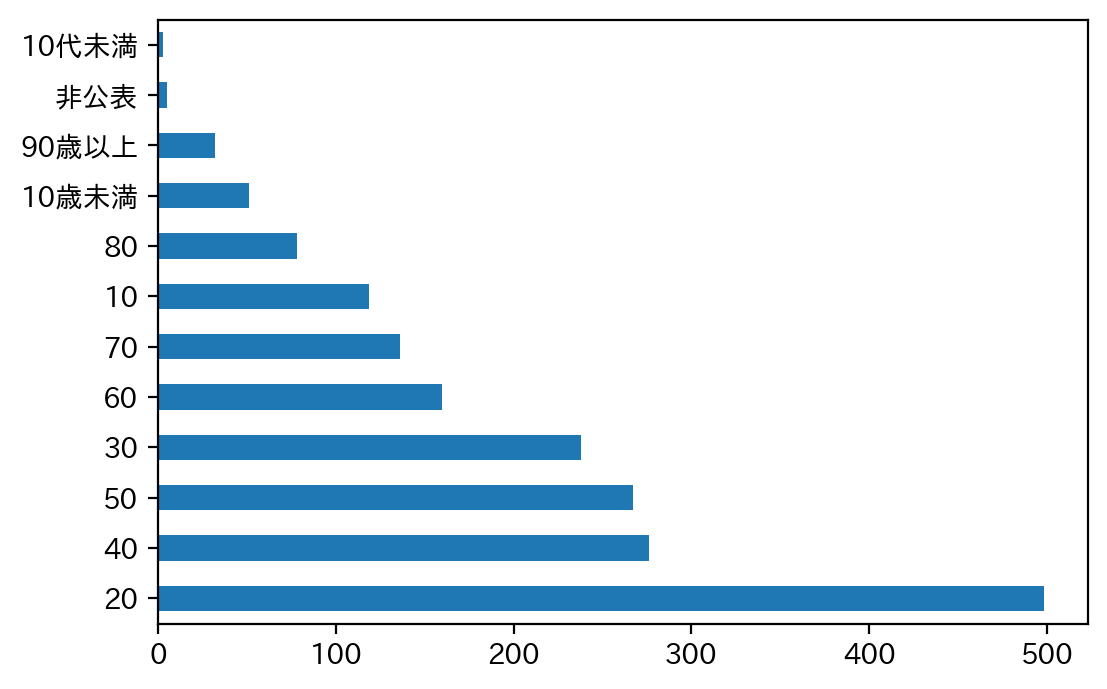

In [24]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [25]:
df_kanja["年代"].value_counts()

20       498
40       276
50       267
30       238
60       160
70       136
10       119
80        78
10歳未満     51
90歳以上     32
非公表        5
10代未満      3
Name: 年代, dtype: int64

In [26]:
ages = ("非公表","10歳未満",10,20,30,40,50,60,70,80,90)

In [27]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["年代"], values=df_kanja["年代"], aggfunc="count").reindex(columns=ages).fillna(0).astype(int)
cr.tail(1)

年代,非公表,10歳未満,10,20,30,40,50,60,70,80,90
発表日,,,,,,,,,,,
2020-08-15,0,2,5,9,10,7,10,5,3,2,0


# 性別確認

## 性別別グラフ

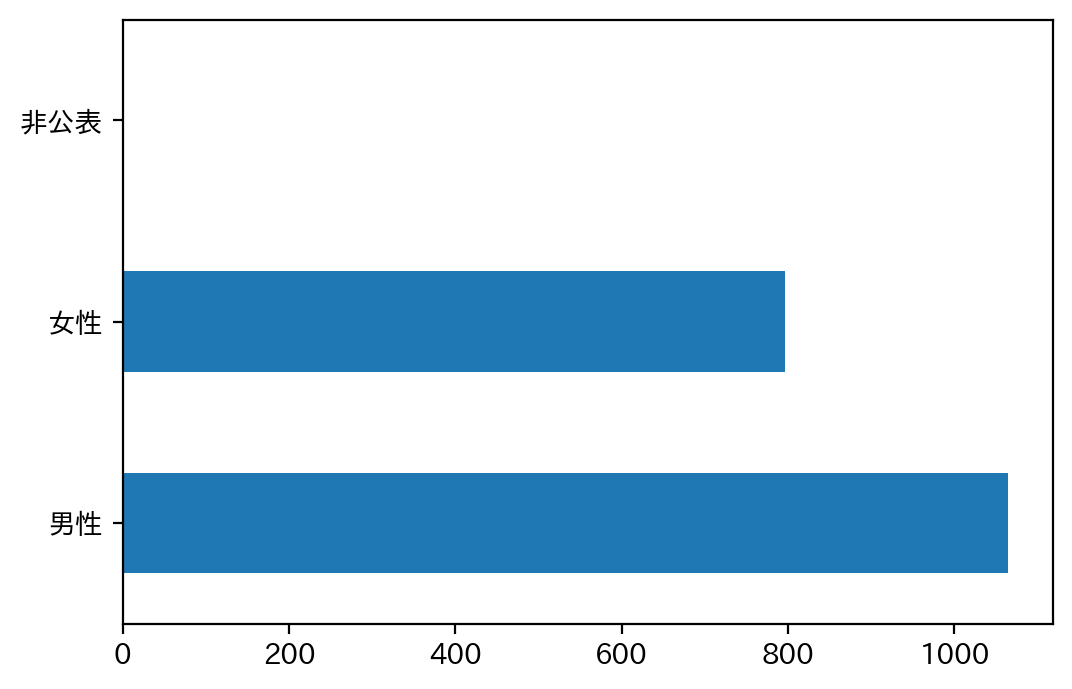

In [28]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [29]:
df_kanja["性別"].value_counts()

男性     1065
女性      796
非公表       2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

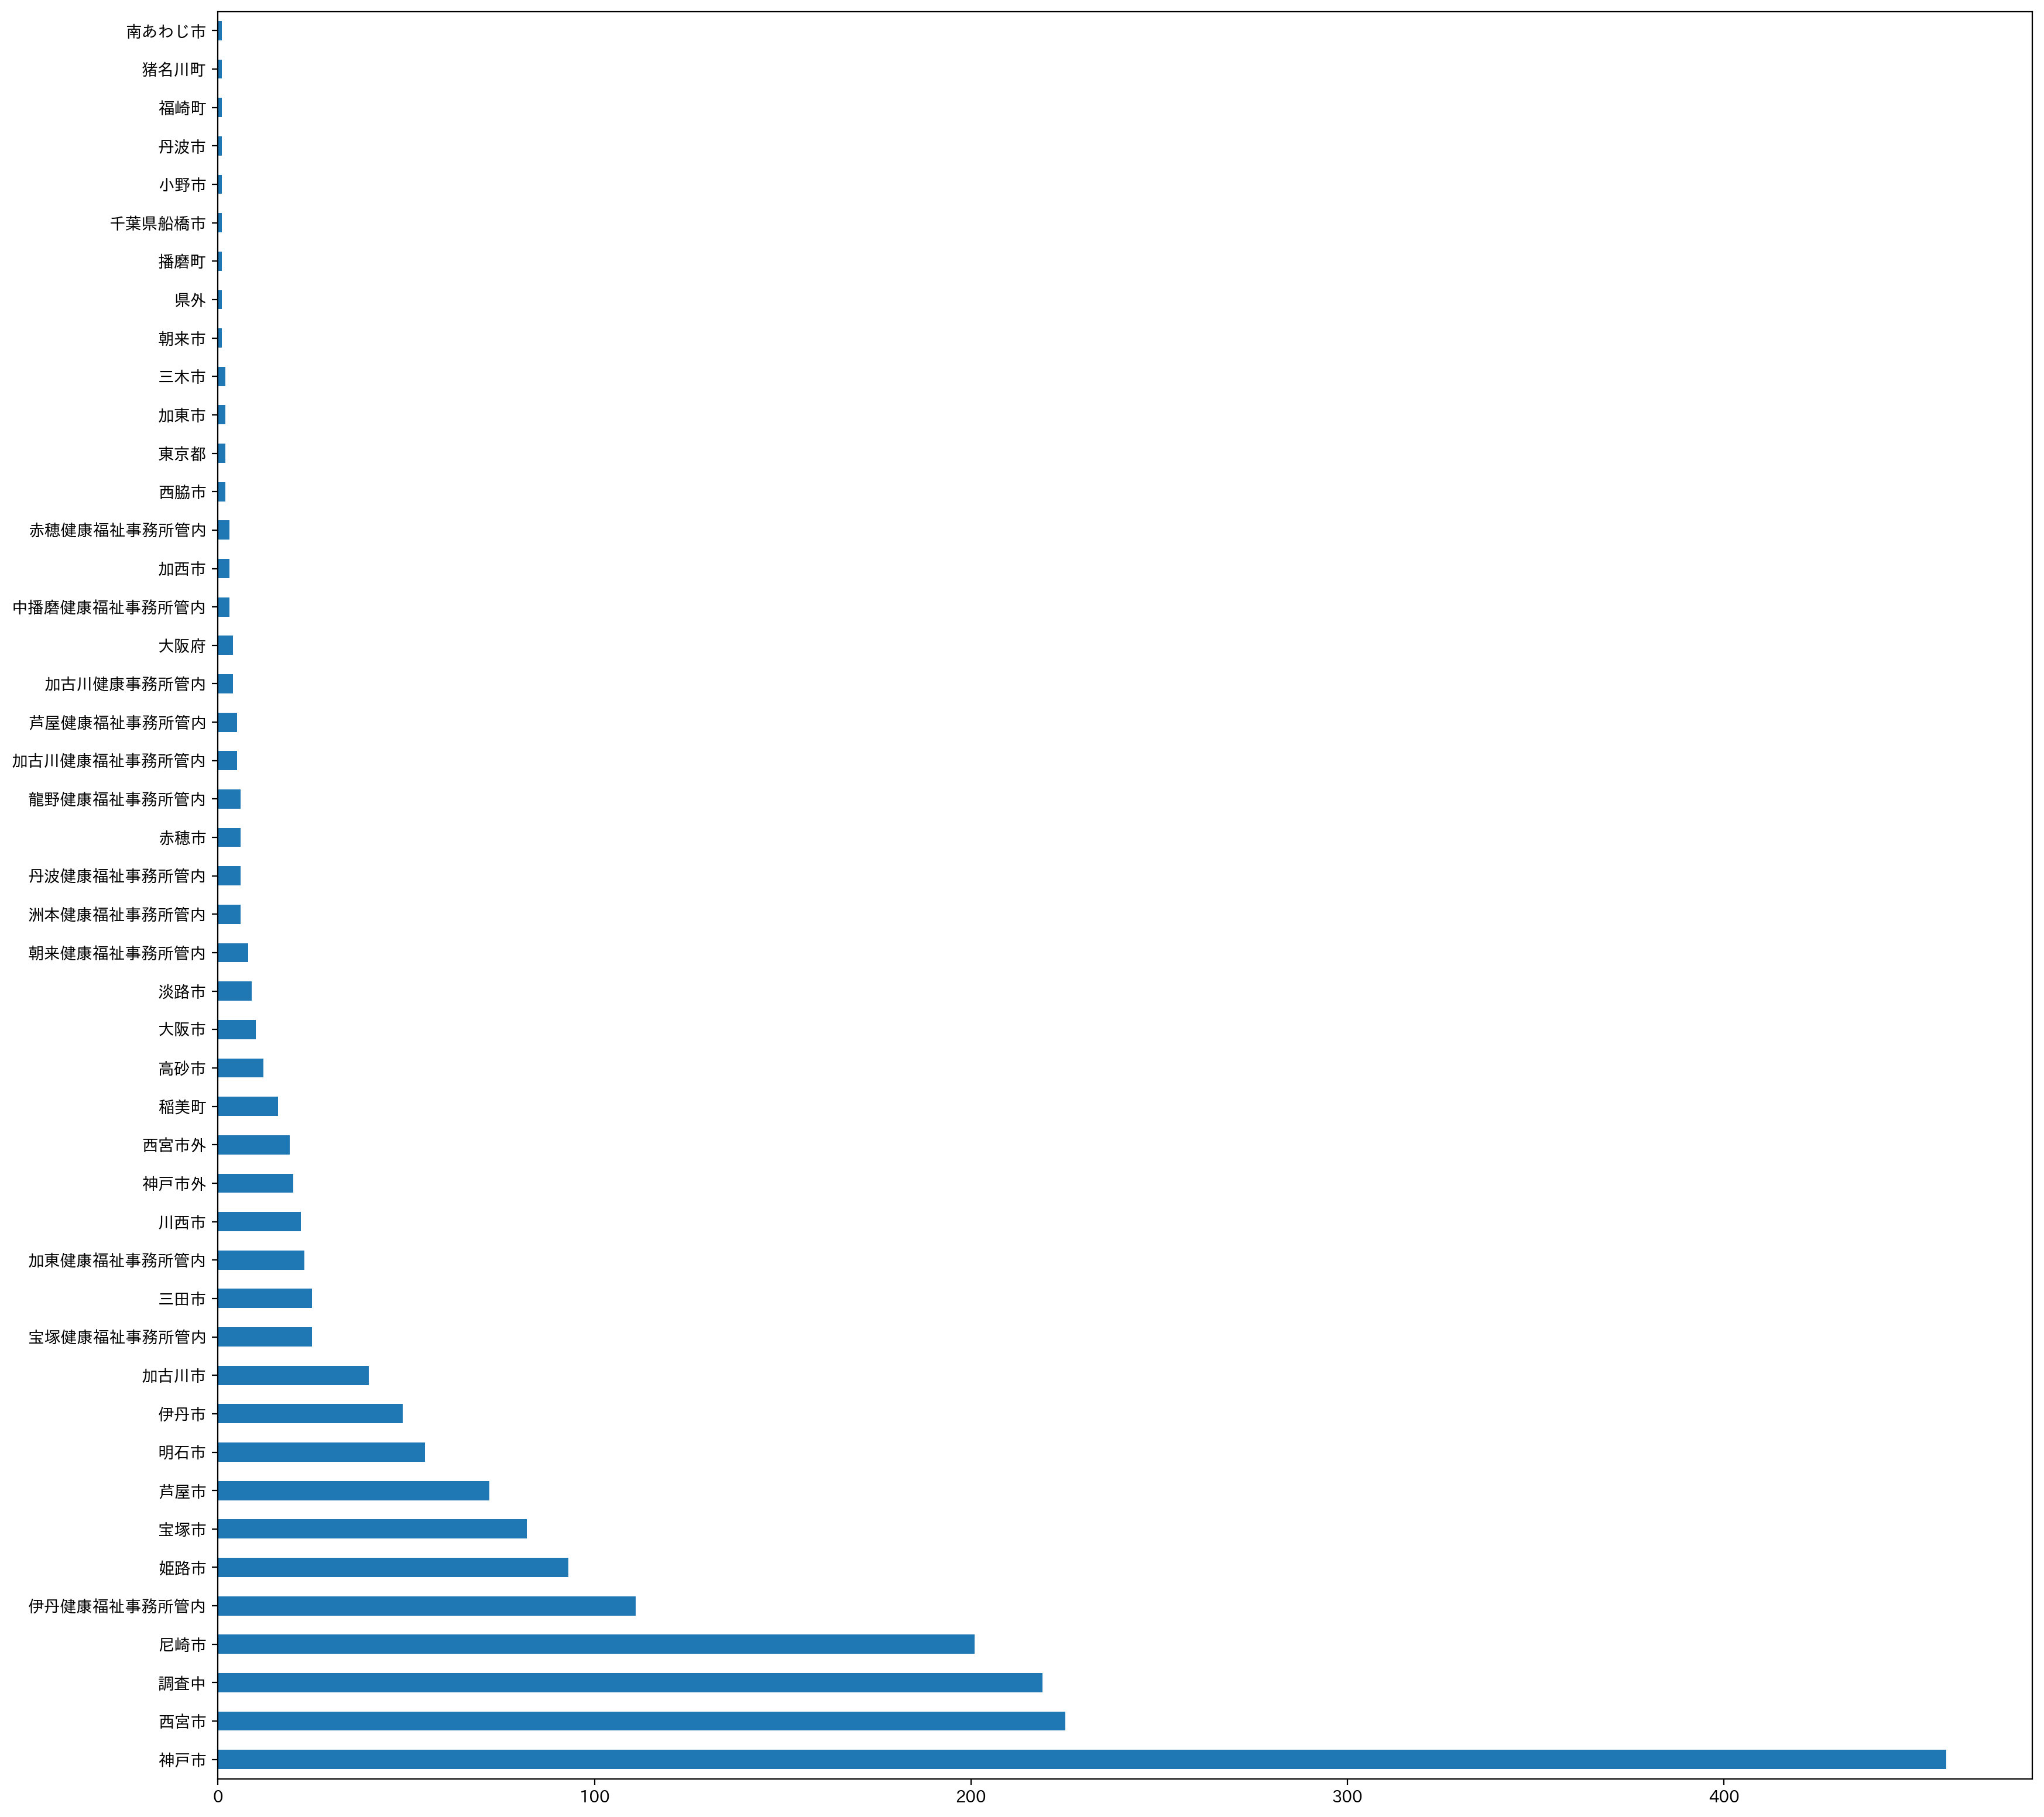

In [30]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [31]:
df_kanja["居住地"].value_counts()

神戸市             459
西宮市             225
調査中             219
尼崎市             201
伊丹健康福祉事務所管内     111
姫路市              93
宝塚市              82
芦屋市              72
明石市              55
伊丹市              49
加古川市             40
宝塚健康福祉事務所管内      25
三田市              25
加東健康福祉事務所管内      23
川西市              22
神戸市外             20
西宮市外             19
稲美町              16
高砂市              12
大阪市              10
淡路市               9
朝来健康福祉事務所管内       8
洲本健康福祉事務所管内       6
丹波健康福祉事務所管内       6
赤穂市               6
龍野健康福祉事務所管内       6
加古川健康福祉事務所管内      5
芦屋健康福祉事務所管内       5
加古川健康事務所管内        4
大阪府               4
中播磨健康福祉事務所管内      3
加西市               3
赤穂健康福祉事務所管内       3
西脇市               2
東京都               2
加東市               2
三木市               2
朝来市               1
県外                1
播磨町               1
千葉県船橋市            1
小野市               1
丹波市               1
福崎町               1
猪名川町              1
南あわじ市             1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

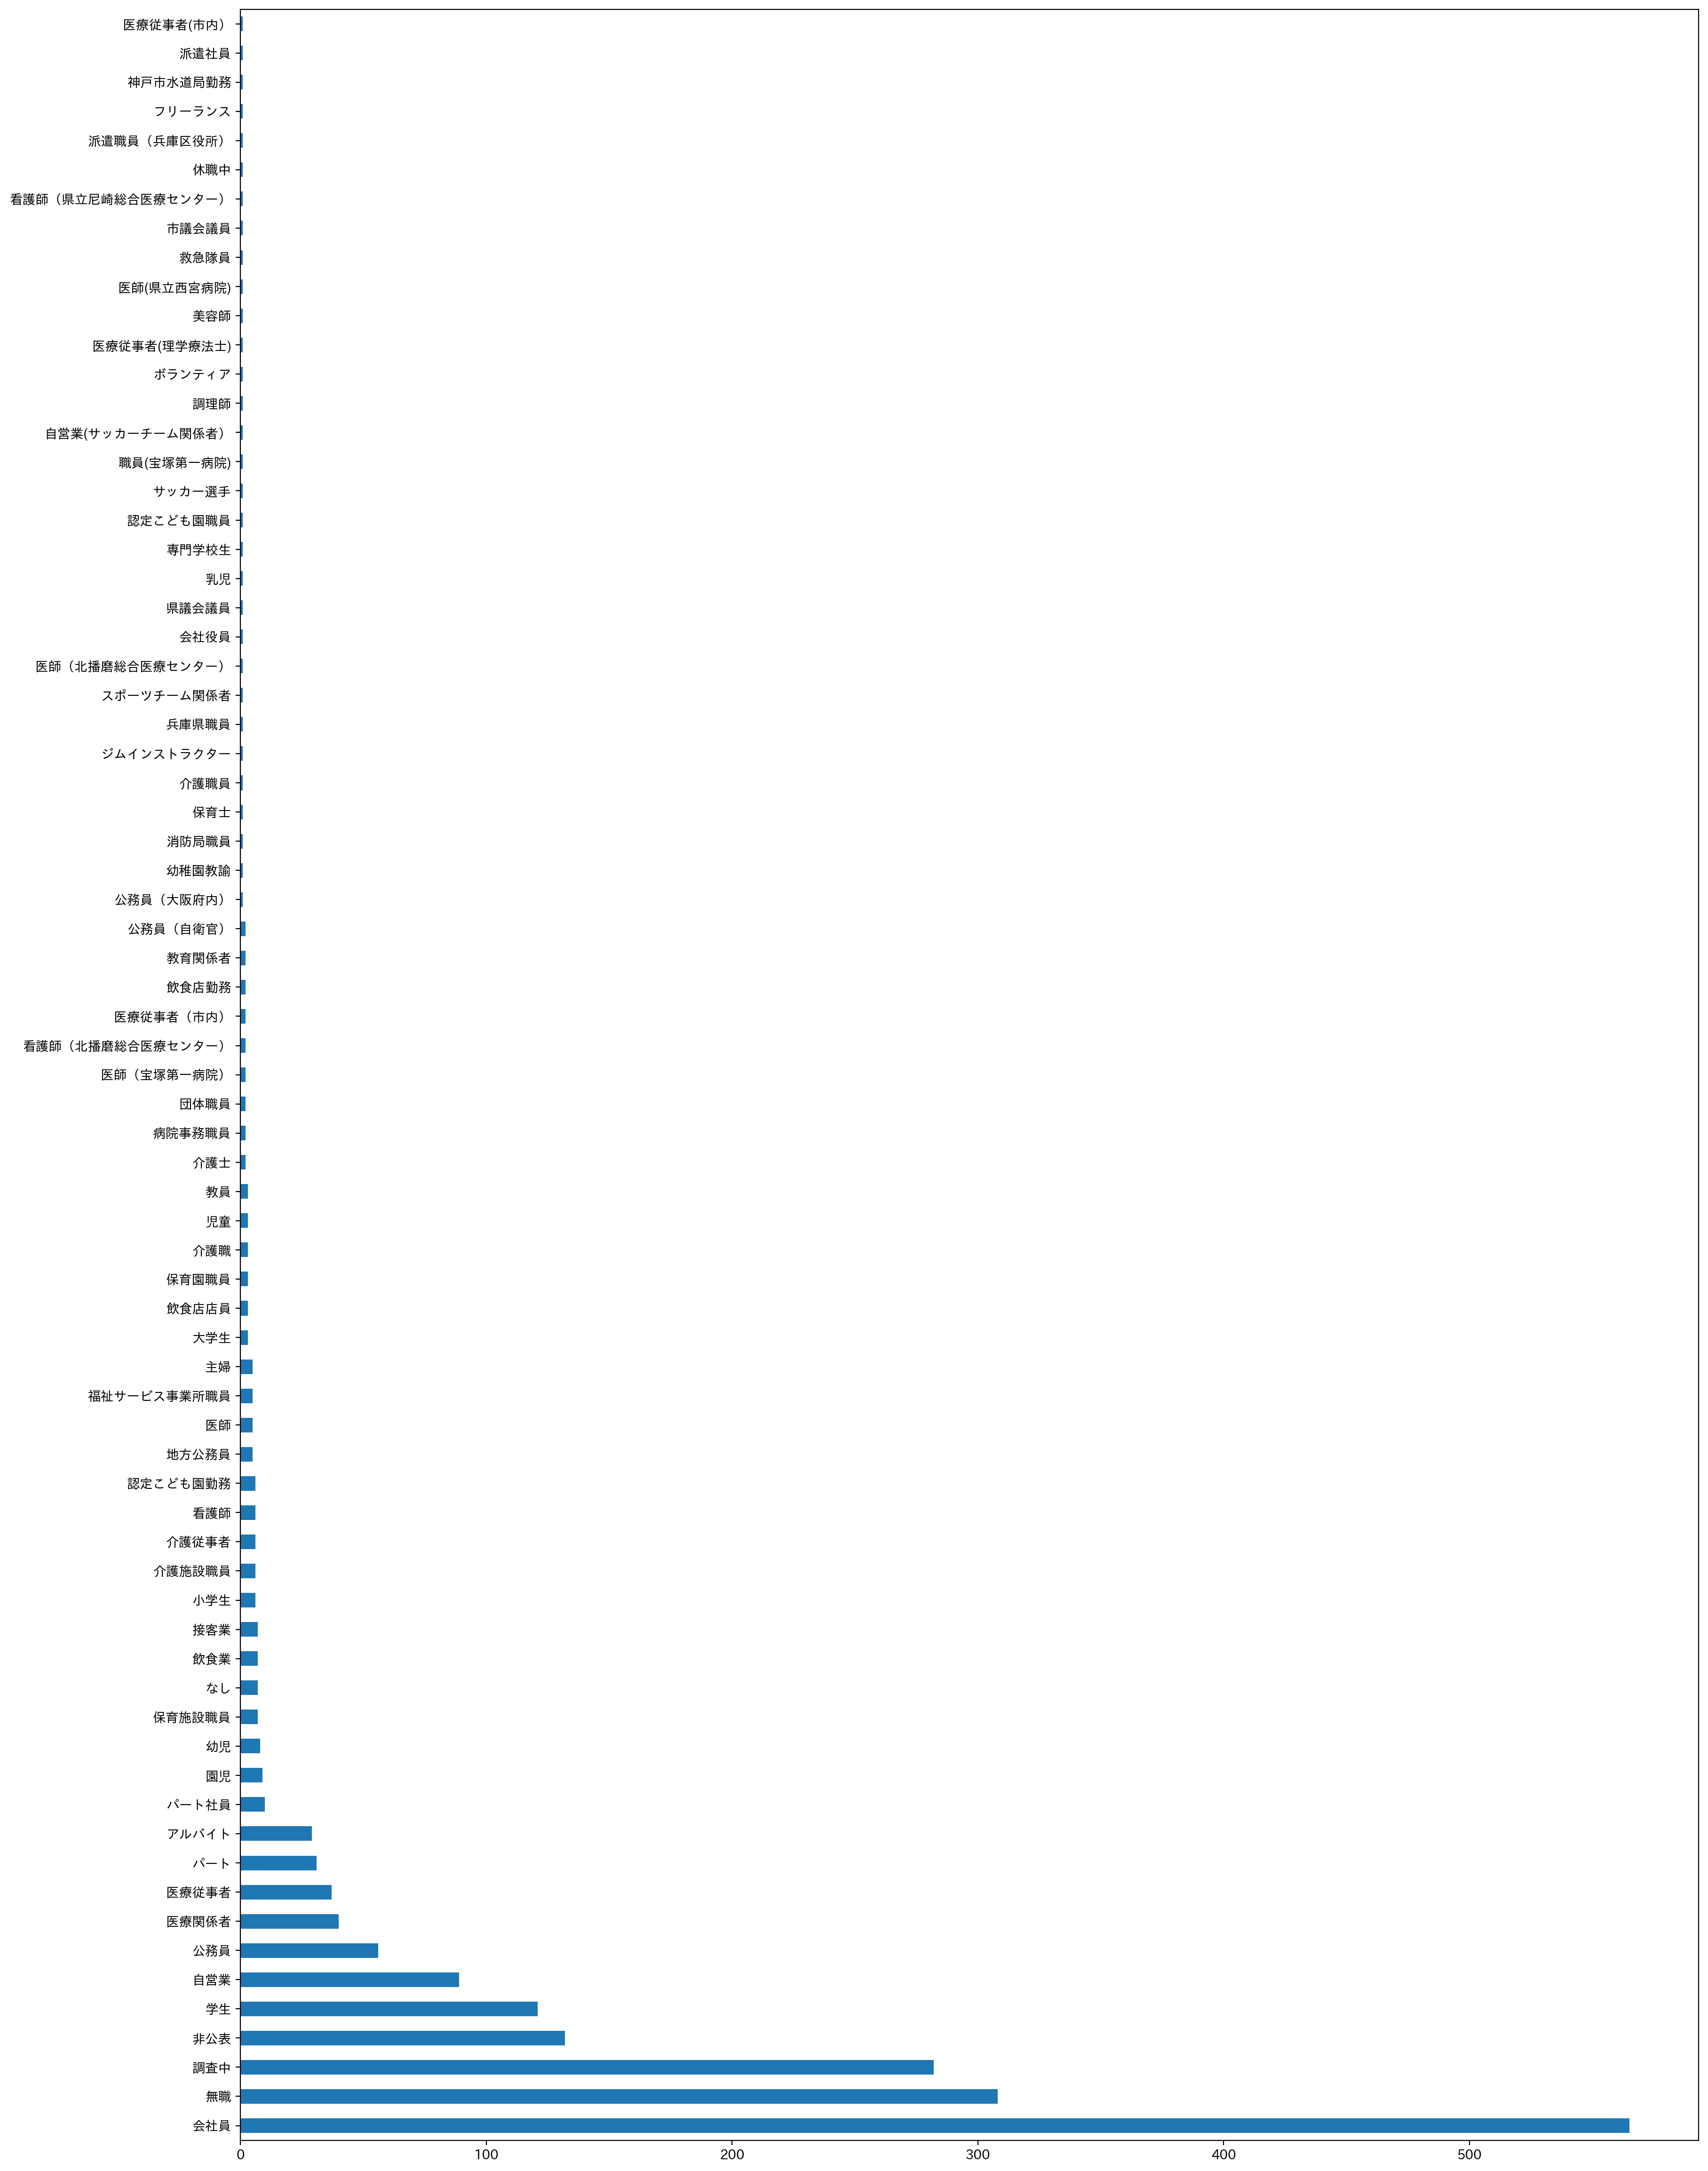

In [32]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [33]:
df_kanja["職業"].value_counts()

会社員            565
無職             308
調査中            282
非公表            132
学生             121
              ... 
派遣職員（兵庫区役所）      1
フリーランス           1
神戸市水道局勤務         1
派遣社員             1
医療従事者(市内）        1
Name: 職業, Length: 73, dtype: int64

# 管轄確認

## 管轄別グラフ

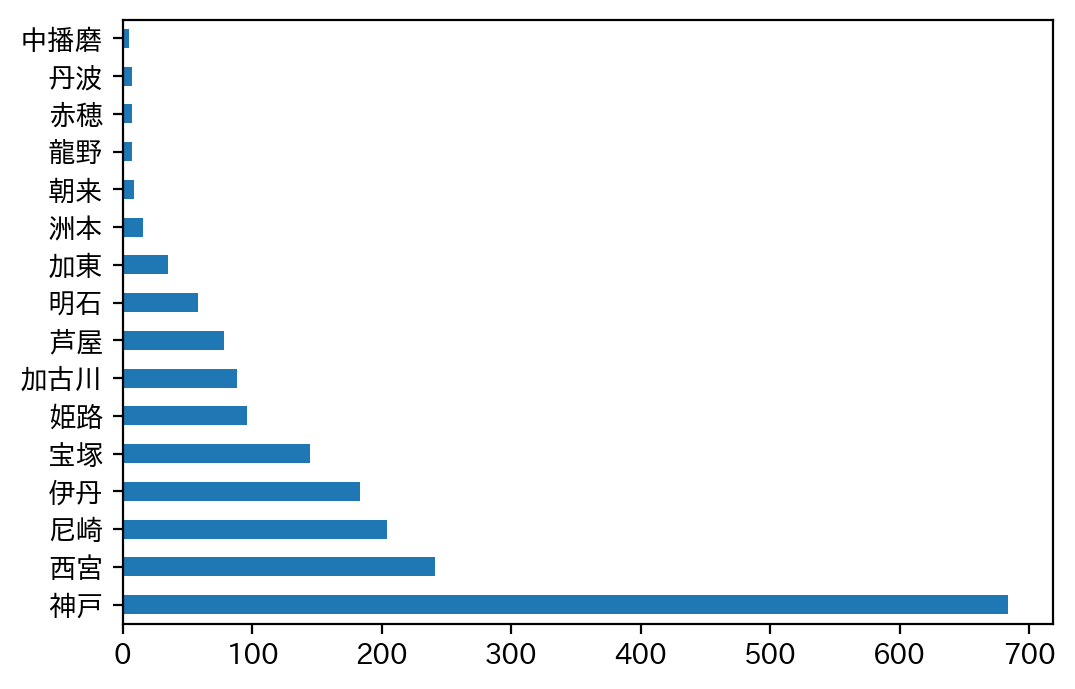

In [34]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [35]:
df_kanja["管轄"].value_counts()

神戸     684
西宮     241
尼崎     204
伊丹     183
宝塚     145
姫路      96
加古川     88
芦屋      78
明石      58
加東      35
洲本      16
朝来       9
龍野       7
赤穂       7
丹波       7
中播磨      5
Name: 管轄, dtype: int64

# 最新

In [36]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["管轄"], values=df_kanja["管轄"], aggfunc="count").reindex(columns=["芦屋","宝塚","伊丹","加古川","加東","中播磨","龍野","赤穂","豊岡","朝来","丹波","洲本","神戸","姫路","尼崎","西宮","明石"]).fillna(0).astype(int)
cr.tail(1)

管轄,芦屋,宝塚,伊丹,加古川,加東,中播磨,龍野,赤穂,豊岡,朝来,丹波,洲本,神戸,姫路,尼崎,西宮,明石
発表日,,,,,,,,,,,,,,,,,
2020-08-15,1,7,6,1,2,0,0,0,0,0,0,0,23,0,6,4,3


In [37]:
cr.sum(axis=1).tail(1)

発表日
2020-08-15    53
dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

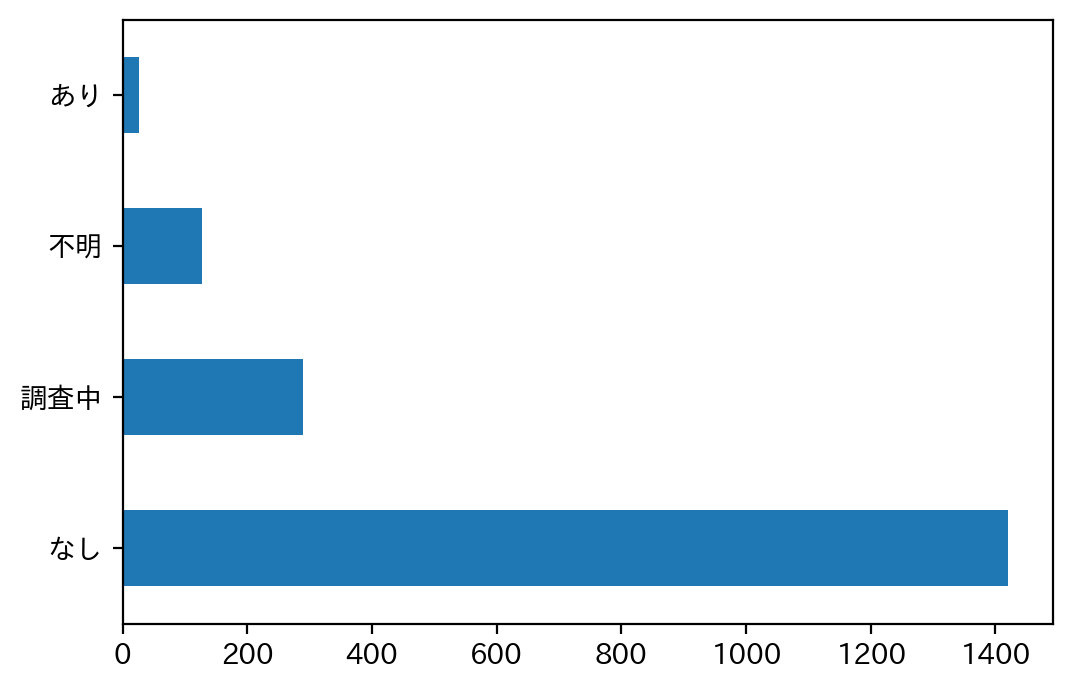

In [38]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [39]:
df_kanja["渡航歴"].value_counts()

なし     1421
調査中     289
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

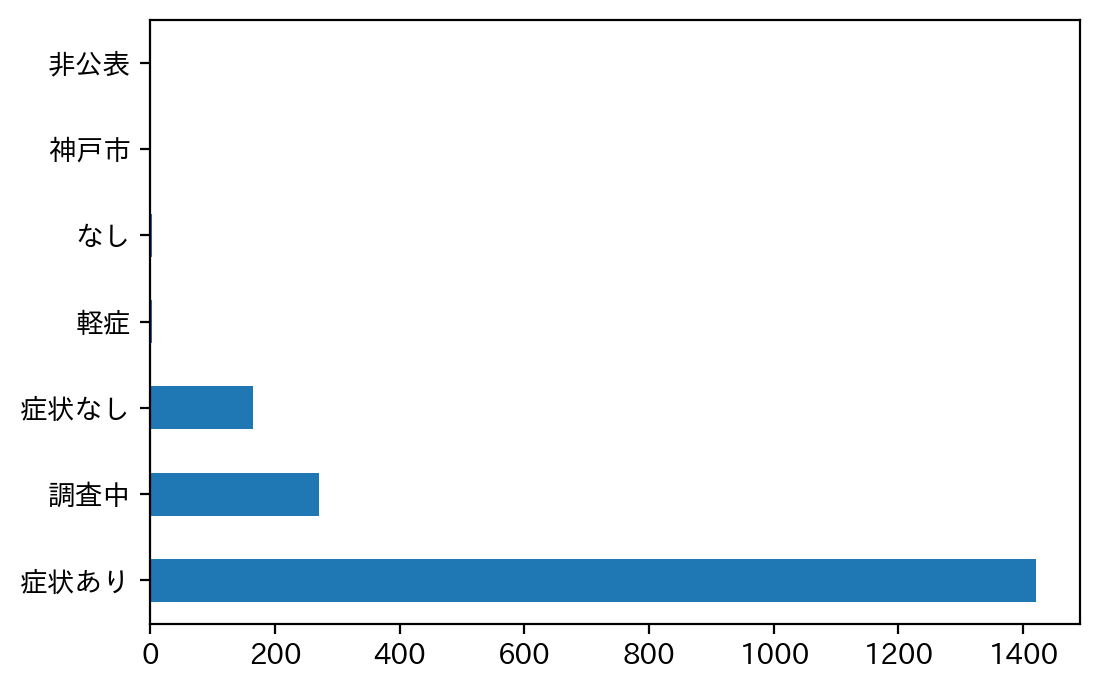

In [40]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [41]:
df_kanja["ステータス"].value_counts()

症状あり    1421
調査中      271
症状なし     165
軽症         2
なし         2
神戸市        1
非公表        1
Name: ステータス, dtype: int64

# 全体確認

In [42]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1864,2020-08-15,50,女性,加東,加東健康福祉事務所管内,パート,2020-08-14,なし,行動歴調査中,症状あり,1.0
1863,2020-08-15,70,女性,加東,加東健康福祉事務所管内,非公表,NaT,なし,行動歴調査中,症状なし,NaN
1862,2020-08-15,40,男性,加古川,加古川市,非公表,2020-08-08,なし,行動歴調査中,症状あり,7.0
1861,2020-08-15,40,男性,伊丹,伊丹健康福祉事務所管内,会社員,NaT,なし,No1728の濃厚接触者,症状なし,NaN
1860,2020-08-15,60,男性,伊丹,川西市,会社員,2020-08-10,なし,No1728の濃厚接触者,症状あり,5.0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり,12.0
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,12.0
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,11.0


# ファイル保存

In [43]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [44]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [45]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# PCR

In [46]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [47]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [48]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-11,627,342,213,72,30
2020-08-12,661,244,337,80,36
2020-08-13,703,300,304,99,48


In [49]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [50]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [51]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [52]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [53]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [54]:
df_yousei = df_yousei.fillna(0).astype(int)

In [55]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [56]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [57]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [58]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 番号

In [59]:
df_kanja[df_kanja.index.duplicated(keep=False)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 年代

In [60]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, "90歳以上", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


### 性別

In [61]:
df_kanja[~df_kanja["性別"].isin(["男性", "女性", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 管轄

In [62]:
df_kanja[
    ~df_kanja["管轄"].isin(
        [
            "芦屋",
            "宝塚",
            "伊丹",
            "加古川",
            "加東",
            "中播磨",
            "龍野",
            "赤穂",
            "豊岡",
            "朝来",
            "丹波",
            "洲本",
            "神戸",
            "姫路",
            "尼崎",
            "西宮",
            "明石",
        ]
    )
]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 居住地

In [63]:
df_kanja[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "健康福祉事務所管内")) & ~(df_kanja["居住地"] == "調査中")]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1251,2020-08-01,60,男性,加古川,加古川健康事務所管内,非公表,2020-07-27,なし,行動歴調査中,症状あり,5.0
1209,2020-07-31,10,女性,加古川,加古川健康事務所管内,非公表,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
1208,2020-07-31,70,女性,加古川,加古川健康事務所管内,無職,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
1055,2020-07-28,40,女性,加古川,加古川健康事務所管内,非公表,2020-07-17,なし,陽性患者の濃厚接触者,症状あり,11.0


### 職業

In [64]:
df_kanja[df_kanja["職業"].astype(str).str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "健康福祉事務所管内"))]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [65]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1698,2020-08-12,90歳以上,女性,神戸,神戸市,無職,NaT,なし,市内介護施設の入所者,軽症,NaN
1695,2020-08-12,90歳以上,女性,神戸,神戸市,無職,NaT,なし,市内介護施設の入所者,軽症,NaN
1019,2020-07-27,20,女性,神戸,神戸市,学生,NaT,なし,感染患者（市外）の濃厚接触者,なし,NaN
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし,NaN
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市,NaN


### 渡航歴

In [66]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [67]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [68]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [69]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [70]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [71]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [72]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [73]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [74]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
